<a href="https://colab.research.google.com/github/yzbaya/FAD.Machine-Learning/blob/main/FAD_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**1.   Préparation des Données**



In [2]:
data = pd.read_csv('histoFAD.csv', encoding='latin1')


<ipython-input-2-a38ad0390545>:1: DtypeWarning: Columns (5,14,22,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('histoFAD.csv', encoding='latin1')


**numeric** **data**

In [3]:
numeric_features = ['NJR','CMJ']
print(data[numeric_features].dtypes)
#extract et imputer les colonnes numeriques
numeric_features = ['NJR','CMJ']
imputer_numeric=SimpleImputer(strategy='median')
data[numeric_features]=imputer_numeric.fit_transform(data[numeric_features])

NJR      int64
CMJ    float64
dtype: object


Nettoyage date

In [4]:
# Nettoyer et traiter les caractéristiques de type date
date_columns = ['DDA', 'DDV']
reference_date = pd.to_datetime('2024-01-01')
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')
    data[col] = (reference_date - data[col]).dt.days

# Imputer les valeurs manquantes pour les dates
imputer = SimpleImputer(strategy='median')
data[date_columns] = imputer.fit_transform(data[date_columns])
print (data[date_columns].isna().sum())

DDA    0
DDV    0
dtype: int64


In [5]:
# List des colonnes à convertir et à imputer
columns_to_convert = ['Vente 2024','Vente 2022','Vente 2023','Ecoulement','DDA','DDV','Stocks','Prix unitaire']

def convert_data(data,columns_to_convert):
    for column in columns_to_convert:
        data[column] = data[column].replace({',': '.'}, regex=True)  # Remplacer les virgules par des points
        data[column] = pd.to_numeric(data[column], errors='coerce')  # Convertir en numérique
        imputer_cols = SimpleImputer(strategy='median')
        data[column] = imputer_cols.fit_transform(data[[column]])  # Imputer les valeurs manquantes
        # data[column] = pd.Series(data[column].flatten()).apply(lambda x: max(x, 0))  # Remplacer les valeurs négatives par zéro
    return data

data=convert_data(data,columns_to_convert)

#test
print("Vérification générale des valeurs manquantes:")
print(data[columns_to_convert].isna().sum())
print(data[numeric_features].isna().sum())

Vérification générale des valeurs manquantes:
Vente 2024       0
Vente 2022       0
Vente 2023       0
Ecoulement       0
DDA              0
DDV              0
Stocks           0
Prix unitaire    0
dtype: int64
NJR    0
CMJ    0
dtype: int64


**categorical data**

In [6]:
# Sélection et imputation des données catégorielles
categorical_features = ['Pareto']
imputer_mostfrequent = SimpleImputer(strategy='most_frequent')
data[categorical_features] = imputer_mostfrequent.fit_transform(data[categorical_features])
print(data[categorical_features].isna().sum())

data['Pareto_copy'] = data['Pareto']
# Mapping importance des pièces
pareto_importance = {
    'AA': 1, 'AB': 2, 'AC': 3, 'AD': 4,
    'BA': 5, 'BB': 6, 'BC': 7, 'BD': 8,
    'CA': 9, 'CB': 10, 'CC': 11, 'CD': 12,
    'DA': 13, 'DB': 14, 'DC': 15, 'DD': 16
}
data['Importance'] = data['Pareto_copy'].map(pareto_importance)

# Encodage one-hot
data = pd.get_dummies(data, columns=['Pareto_copy'], prefix='Pareto')


# Afficher les premières lignes du dataframe pour une vérification visuelle
# print(data.head())


Pareto    0
dtype: int64


normalisation of data

In [7]:
#Normalisation des donées
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_to_scale = ['Vente 2024','Vente 2022','Vente 2023','Ecoulement','DDA','DDV','Stocks','Prix unitaire']
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [8]:

from sklearn.model_selection import train_test_split
features = ['NJR', 'CMJ', 'Vente 2022', 'Ecoulement', 'Importance','DDA','DDV','Stocks','Prix unitaire'] + [col for col in data.columns if col.startswith('Pareto_')]
X=data[features]
y=data['Vente 2023']
# Vérifier à nouveau les valeurs manquantes dans y
print("Vérification des valeurs manquantes dans y après suppression des lignes:")
print(data['Vente 2023'].isna().sum())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Vérification des valeurs manquantes dans y après suppression des lignes:
0


**2.  Entrainement du model**



In [9]:
# Entraîner le modèle de Random Forest
randomforest = RandomForestRegressor(random_state=42)
randomforest.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = randomforest.predict(X_test)

# Évaluer les prédictions
mae_rf = mean_absolute_error(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}")

Random Forest - MAE: 0.043985345209909946, MSE: 0.006404506385760034


In [13]:
comparison_df = pd.DataFrame({
    'Valeurs Réelles': y_test,
    'Valeurs Prédites': y_pred
})

# Évaluer les prédictions
mae_rf = mean_absolute_error(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}")

# Afficher les premières lignes du tableau avec un style pour mieux visualiser
comparison_df.head(10).style.background_gradient(cmap='viridis')

Random Forest - MAE: 0.043985345209909946, MSE: 0.006404506385760034


,Valeurs Réelles,Valeurs Prédites
2714,0.640258,0.640258
11907,0.640258,0.711065
10337,0.640258,0.640258
14801,0.640258,0.640258
10945,0.640258,0.647117
12333,0.486562,0.509611
2006,0.640258,0.640258
8939,0.640258,0.661696
12211,0.640258,0.640258
13320,0.710592,0.659827


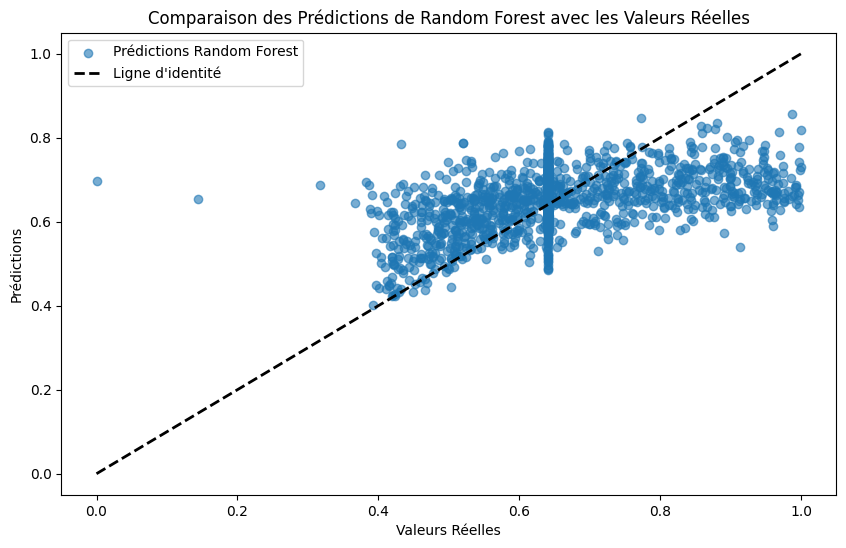

In [14]:
# Afficher les prédictions par rapport aux valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Prédictions Random Forest')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Ligne d\'identité')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des Prédictions de Random Forest avec les Valeurs Réelles')
plt.legend()
plt.show()


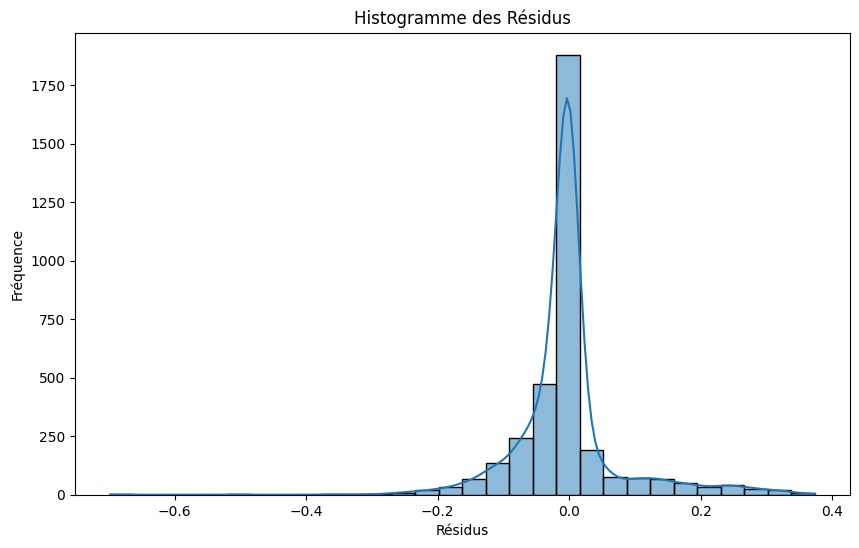

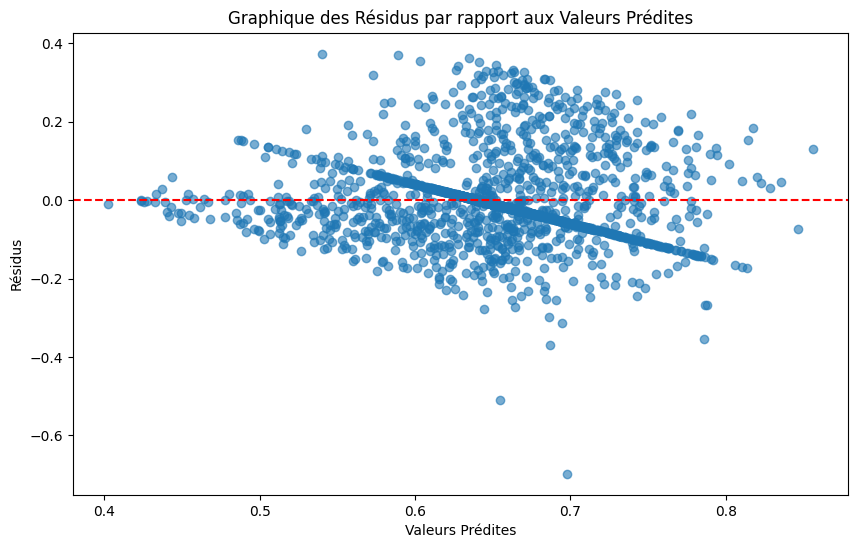

In [16]:
# Calculer les résidus
residuals = y_test - y_pred

# un histogramme des résidus
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogramme des Résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

# les résidus par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title('Graphique des Résidus par rapport aux Valeurs Prédites')
plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')
plt.show()